Data used for cleaning: 

https://data.cityofnewyork.us/Public-Safety/NYPD-Complaint-Data-Current-Year-To-Date-/5uac-w243/about_data

Overall thoughts:
- Seems to be nearly everywhere...
- Recency is also an issue

# Imports


In [3]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import contextily as ctx
import seaborn as sns

# NYPD Complaint Data Visualization

/var/folders/7b/0zqwym191dq_5jvhhbf5lfgr0000gn/T/ipykernel_38641/501180219.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  gdf = pd.read_csv('/Users/naliniramanathan/projects/se_1/team2-wed-spring25/input_data/NYPD_Complaint_Data_Current__Year_To_Date__20250220.csv')


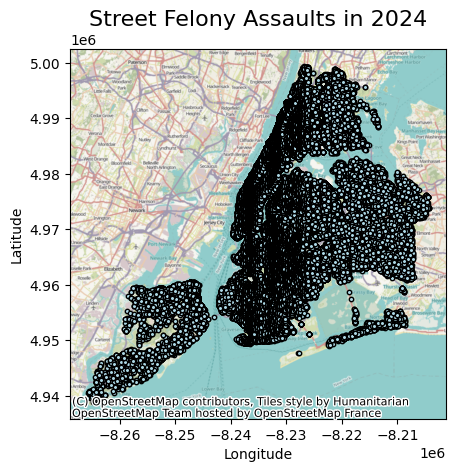

In [4]:
gdf = pd.read_csv('/Users/naliniramanathan/projects/se_1/team2-wed-spring25/input_data/NYPD_Complaint_Data_Current__Year_To_Date__20250220.csv')

gdf = gpd.GeoDataFrame(gdf, geometry=gpd.points_from_xy(gdf['Longitude'], gdf['Latitude']))

# First, set the CRS to WGS84 (EPSG:4326), as it's standard for lat/lon
gdf.set_crs(epsg=4326, allow_override=True, inplace=True)

# Clean the data: Filter out rows with NaN latitudes or longitudes
gdf = gdf[gdf['Latitude'].notna() & gdf['Longitude'].notna()]

# Remove the rows with invalid latitudes and longitudes
gdf = gdf[(gdf['Latitude'] <= 50) & (gdf['Latitude'] >= 40)]
gdf = gdf[(gdf['Longitude'] <= -60) & (gdf['Longitude'] >= -80)]


# Extract some additional time data
gdf['CMPLNT_FR_DT'] = pd.to_datetime(gdf['CMPLNT_FR_DT'], format='%m/%d/%Y', errors='coerce')
gdf['Month'] = gdf['CMPLNT_FR_DT'].dt.month
gdf['DayOfWeek'] = gdf['CMPLNT_FR_DT'].dt.dayofweek  # 0 = Monday, 6 = Sunday
gdf['Year'] = gdf['CMPLNT_FR_DT'].dt.year

gdf['CMPLNT_TO_TM'] = pd.to_datetime(gdf['CMPLNT_TO_TM'], format='%H:%M:%S', errors='coerce')
gdf['Hour'] = gdf['CMPLNT_TO_TM'].apply(lambda x: x.hour if pd.notna(x) else None)


# Convert latitude and longitude to numeric values (if they are not already)
gdf['Latitude'] = pd.to_numeric(gdf['Latitude'], errors='coerce')
gdf['Longitude'] = pd.to_numeric(gdf['Longitude'], errors='coerce')

# Ensure the geometry column is in the correct CRS (WGS84)
gdf = gdf.to_crs(epsg=3857)

crime_type = 'FELONY ASSAULT'
gdf_map = gdf[gdf['OFNS_DESC'] == crime_type]

gdf_map = gdf[gdf['PREM_TYP_DESC'] == 'STREET']

gdf_map = gdf_map[gdf_map['CMPLNT_FR_DT'] >= '01/01/2024']

# Optionally, scatter plot the latitudes with color
# Points will be color-coded based on latitude
# fig, ax = plt.subplots(figsize=(10, 10))

# Plot the geometries (points) on the map
ax = gdf_map.plot(color='lightblue', edgecolor='black', marker='o', markersize=10)

ctx.add_basemap(ax)

# Add a title and labels
plt.title("Street Felony Assaults in 2024", fontsize=16)
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# min_longitude = -74.03  # Example: New York's longitude
# max_longitude = -73.90
# min_latitude = 40.70    # Example: New York's latitude
# max_latitude = 40.80

# Set the zoom level by adjusting xlim and ylim
# ax.set_xlim(min_longitude, max_longitude)
# ax.set_ylim(min_latitude, max_latitude)

# Show the plot
plt.show()

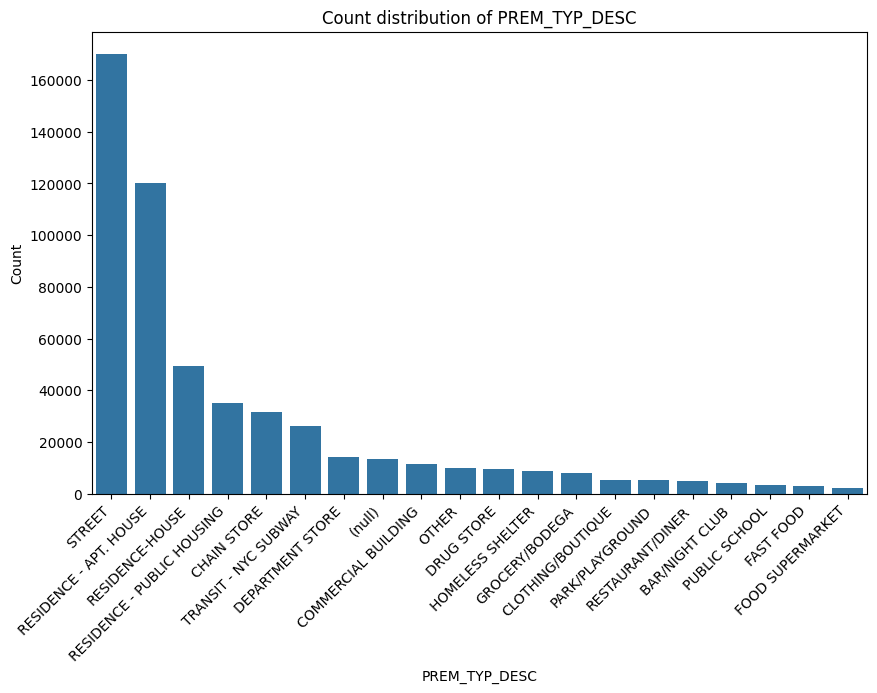

Showing count distribution for column: PREM_TYP_DESC


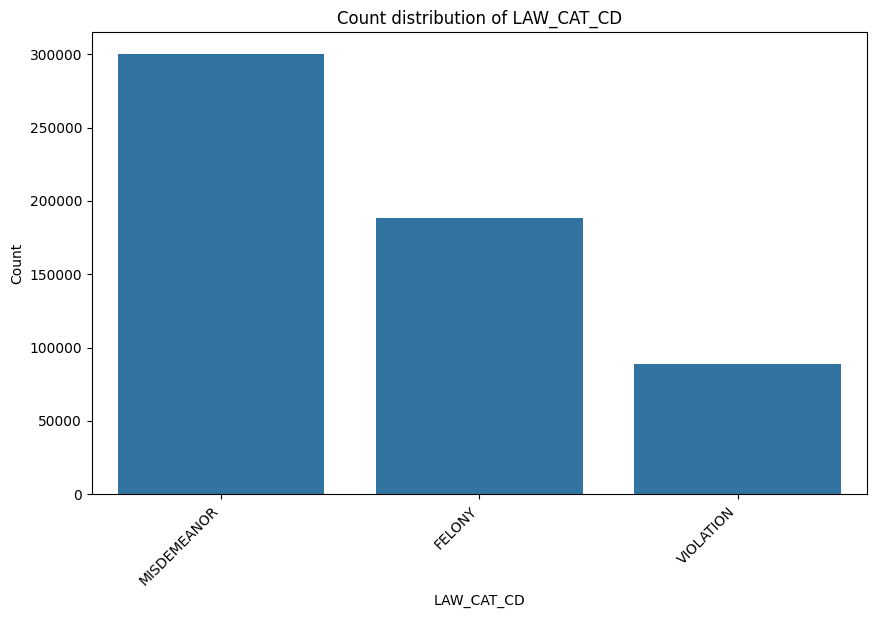

Showing count distribution for column: LAW_CAT_CD


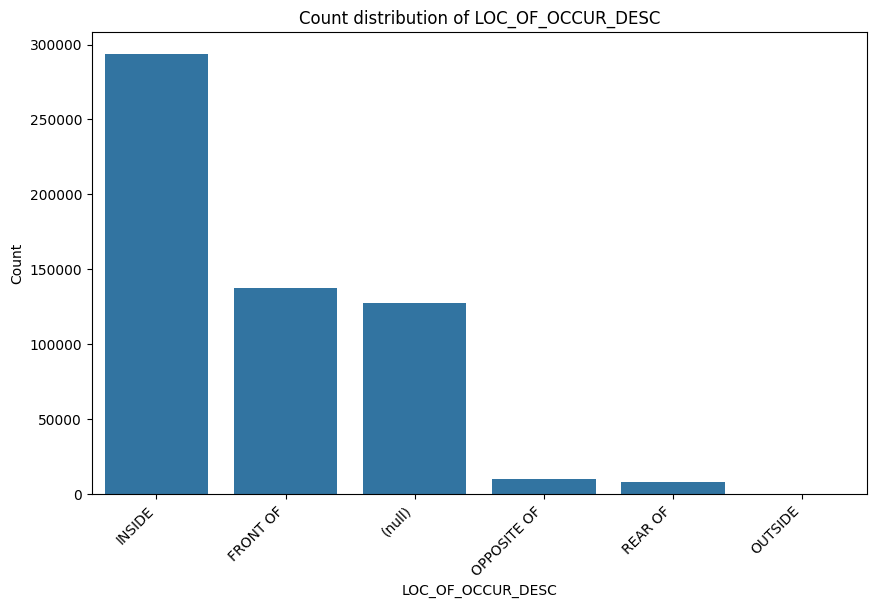

Showing count distribution for column: LOC_OF_OCCUR_DESC


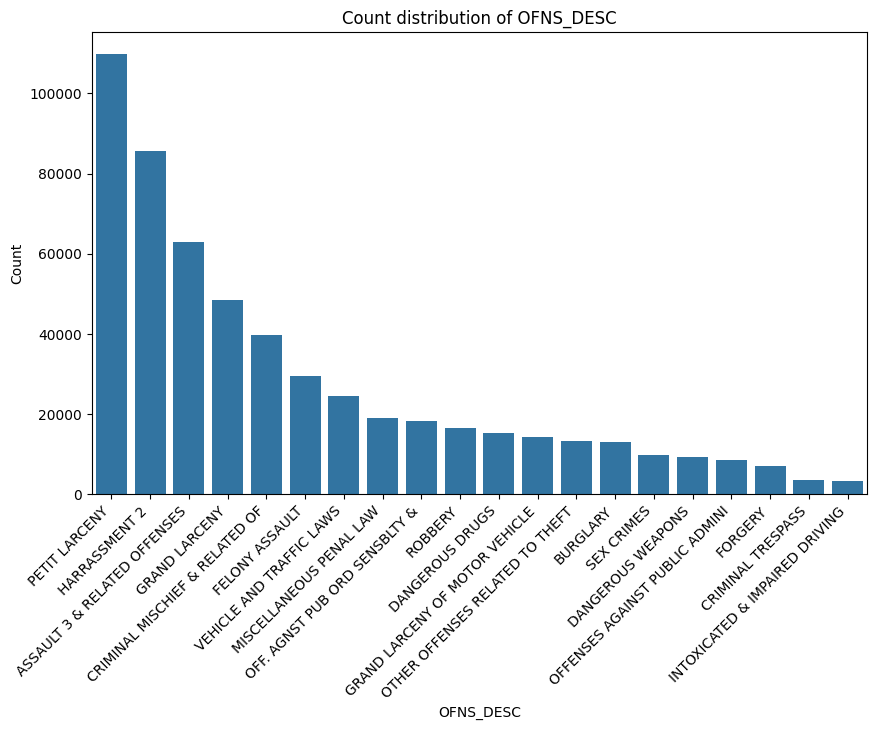

Showing count distribution for column: OFNS_DESC


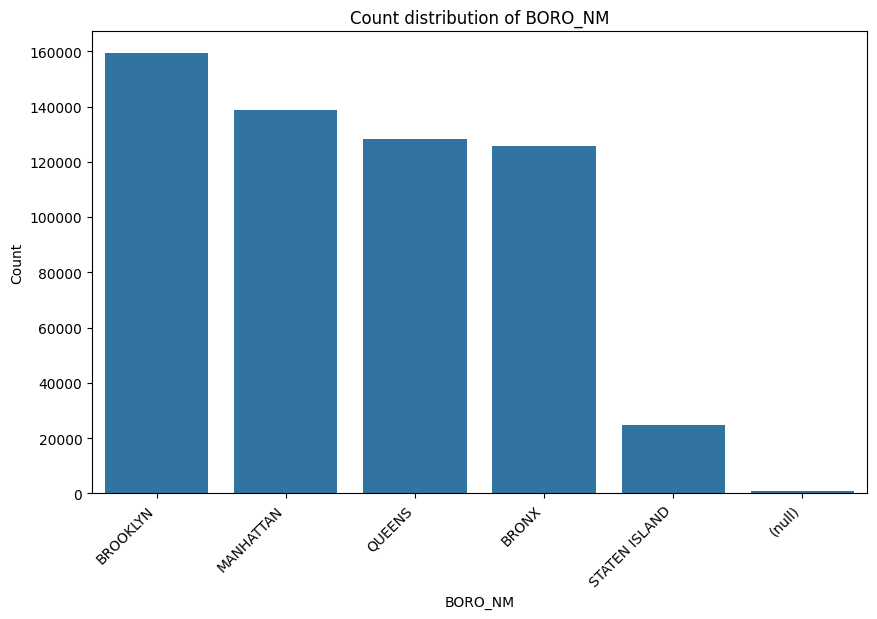

Showing count distribution for column: BORO_NM


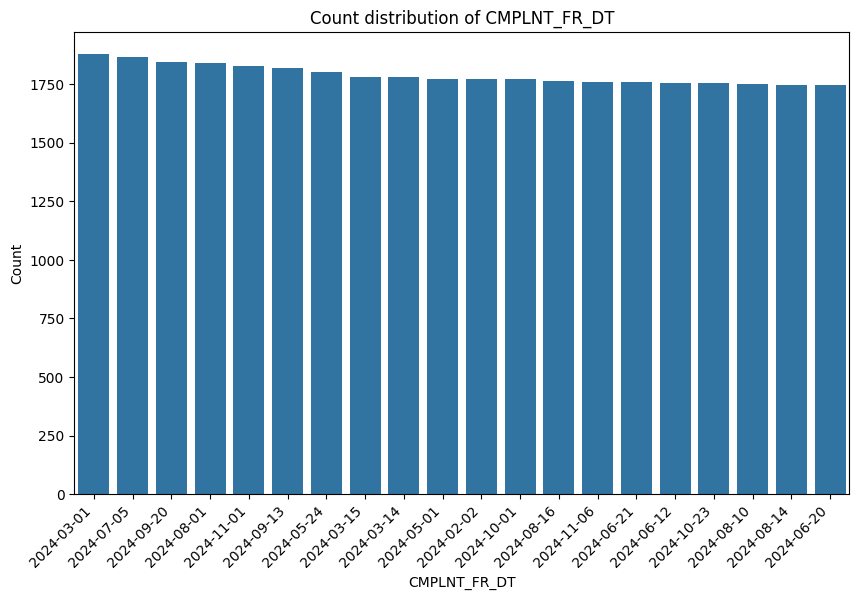

Showing count distribution for column: CMPLNT_FR_DT


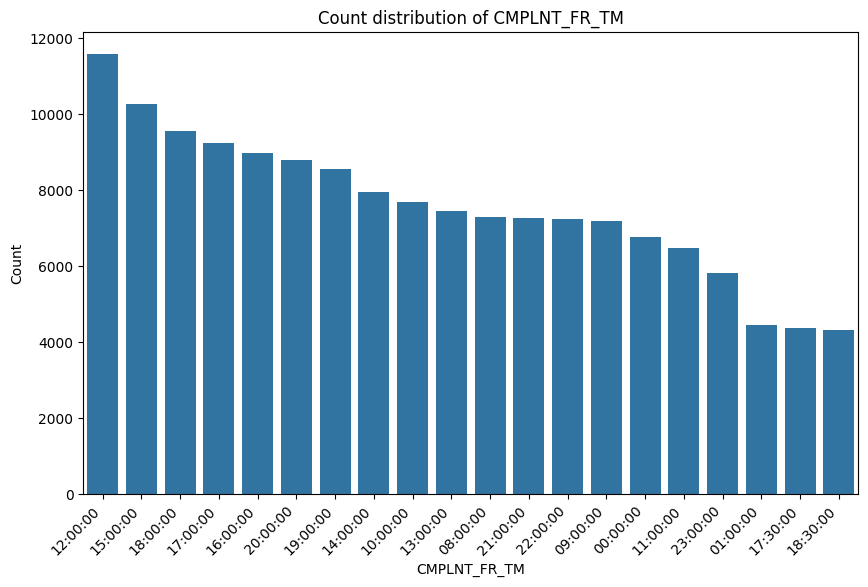

Showing count distribution for column: CMPLNT_FR_TM


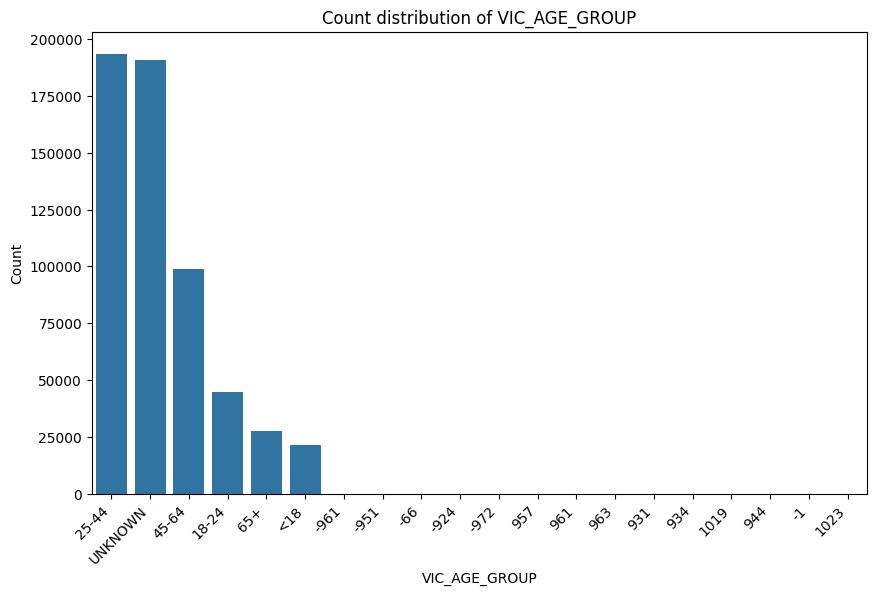

Showing count distribution for column: VIC_AGE_GROUP


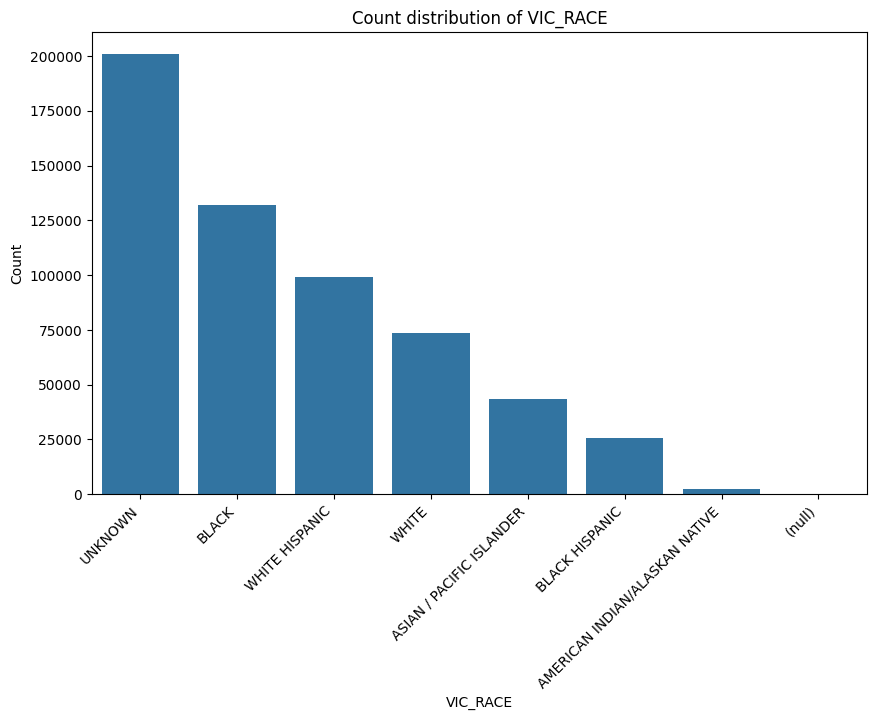

Showing count distribution for column: VIC_RACE


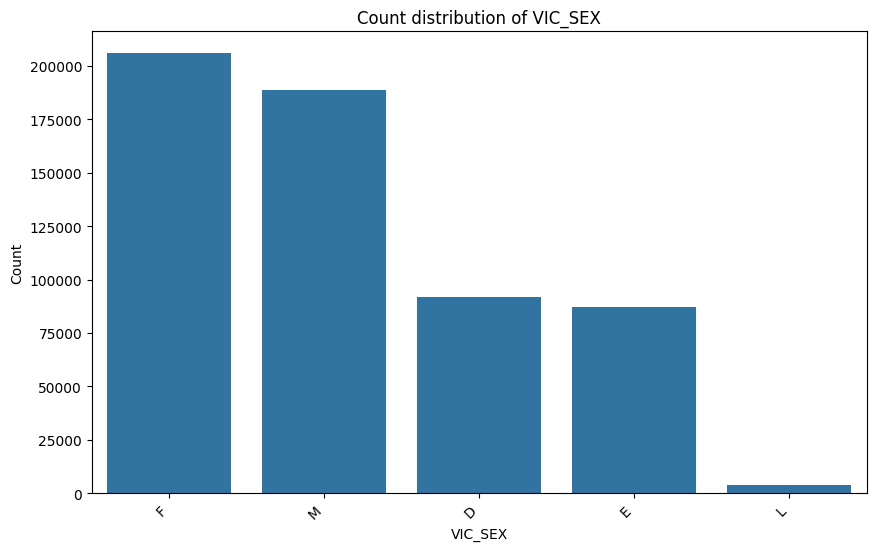

Showing count distribution for column: VIC_SEX


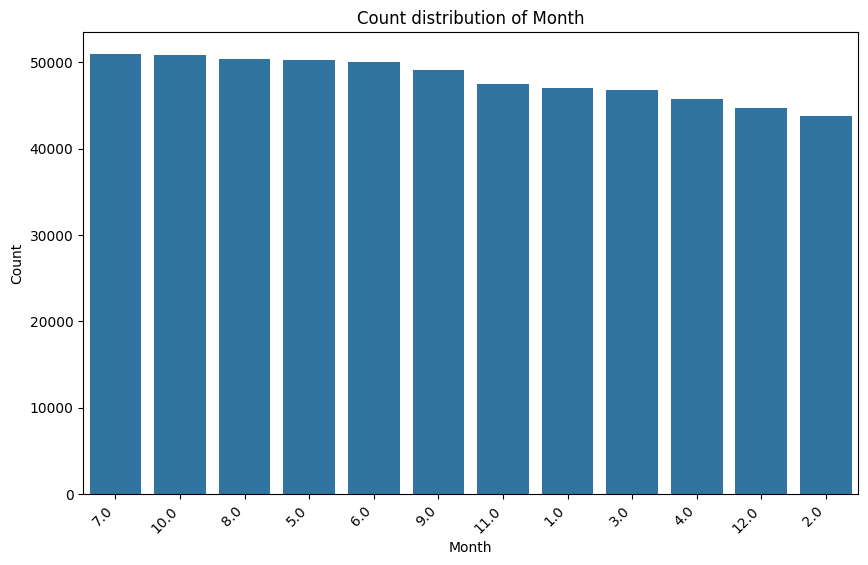

Showing count distribution for column: Month


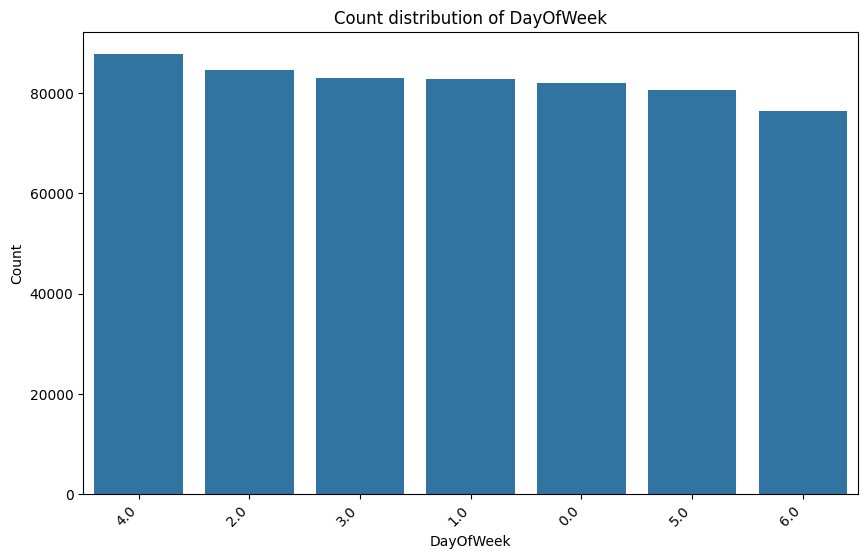

Showing count distribution for column: DayOfWeek


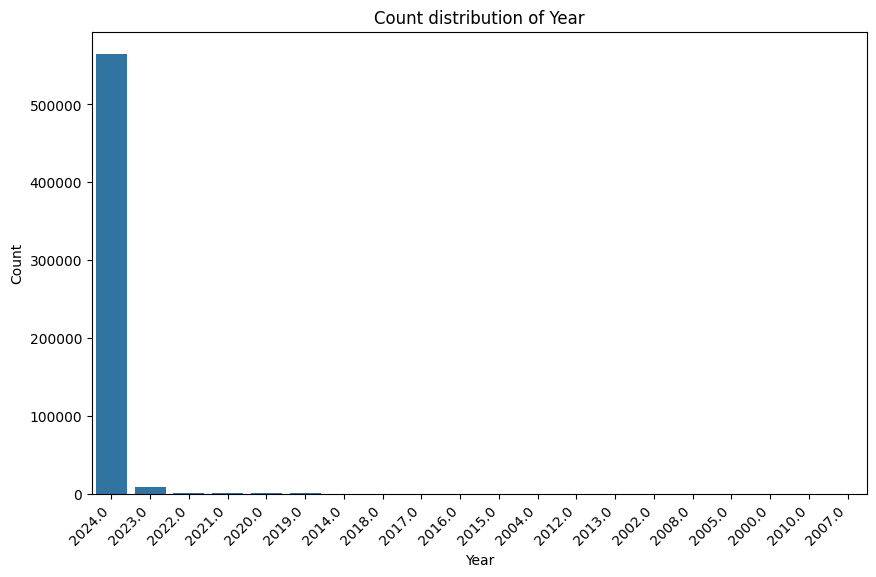

Showing count distribution for column: Year


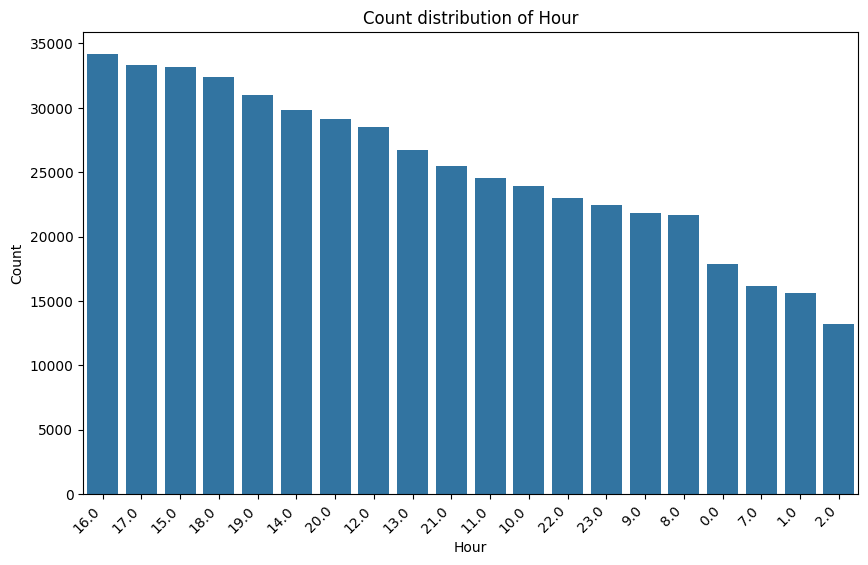

Showing count distribution for column: Hour


In [5]:
columns_of_interest = ['PREM_TYP_DESC', 'LAW_CAT_CD', 'LOC_OF_OCCUR_DESC', 'OFNS_DESC', 'BORO_NM', 'CMPLNT_FR_DT', 'CMPLNT_FR_TM', 'VIC_AGE_GROUP', 'VIC_RACE', 'VIC_SEX', 'Month', 'DayOfWeek', 'Year', 'Hour']

for column in columns_of_interest:
    # Get the count of unique values and filter out low frequency categories if needed
    counts = gdf[column].value_counts()
    
    # Optionally, limit the number of categories shown, e.g., show top 10 most frequent
    top_counts = counts.head(20)  # Adjust this number based on your needs
    
    plt.figure(figsize=(10, 6))
    sns.countplot(x=gdf[column], order=top_counts.index)  # Order by frequency of top counts
    plt.title(f'Count distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Count')
    
    # Rotate the x-axis labels if there are many categories
    plt.xticks(rotation=45, ha='right')
    
    # Show the plot
    plt.show()
    
    print(f"Showing count distribution for column: {column}")


In [6]:
gdf_final = gdf[columns_of_interest]
gdf_final.head()

PREM_TYP_DESC LAW_CAT_CD LOC_OF_OCCUR_DESC       OFNS_DESC  \
1         PARK/PLAYGROUND     FELONY            INSIDE            RAPE   
2  RESIDENCE - APT. HOUSE     FELONY            INSIDE           ARSON   
4                  STREET     FELONY            (null)            RAPE   
5               FAST FOOD     FELONY            INSIDE  FELONY ASSAULT   
6         RESIDENCE-HOUSE     FELONY            INSIDE           ARSON   

     BORO_NM CMPLNT_FR_DT CMPLNT_FR_TM VIC_AGE_GROUP VIC_RACE VIC_SEX  Month  \
1      BRONX   2021-02-01     16:00:00           <18    BLACK       F    2.0   
2  MANHATTAN   2024-08-24     00:38:00         25-44  UNKNOWN       F    8.0   
4   BROOKLYN   2024-08-30     14:55:00         18-24    BLACK       F    8.0   
5      BRONX   2024-06-09     12:37:00           65+    BLACK       M    6.0   
6      BRONX   2024-12-26     07:56:00         25-44    BLACK       M   12.0   

   DayOfWeek    Year  Hour  
1        0.0  2021.0   NaN  
2        5.0  2024.0   NaN  
4        4.0  2024.0  15.0  
5        6.0  2024.0   NaN  
6        3.0  2024.0   NaN

# Road Level Analysis

In [7]:
ny_roads_1 = gpd.read_file('/Users/naliniramanathan/projects/se_1/team2-wed-spring25/input_data/tl_2024_36005_roads/tl_2024_36005_roads.shp')
ny_roads_2 = gpd.read_file('/Users/naliniramanathan/projects/se_1/team2-wed-spring25/input_data/tl_2024_36047_roads/tl_2024_36047_roads.shp')
ny_roads_3 = gpd.read_file('/Users/naliniramanathan/projects/se_1/team2-wed-spring25/input_data/tl_2024_36061_roads/tl_2024_36061_roads.shp')
ny_roads_4 = gpd.read_file('/Users/naliniramanathan/projects/se_1/team2-wed-spring25/input_data/tl_2024_36081_roads/tl_2024_36081_roads.shp')
ny_roads_5 = gpd.read_file('/Users/naliniramanathan/projects/se_1/team2-wed-spring25/input_data/tl_2024_36085_roads/tl_2024_36085_roads.shp')
ny_roads_final = gpd.GeoDataFrame(pd.concat([ny_roads_1, ny_roads_2, ny_roads_3, ny_roads_4, ny_roads_5], ignore_index=True))


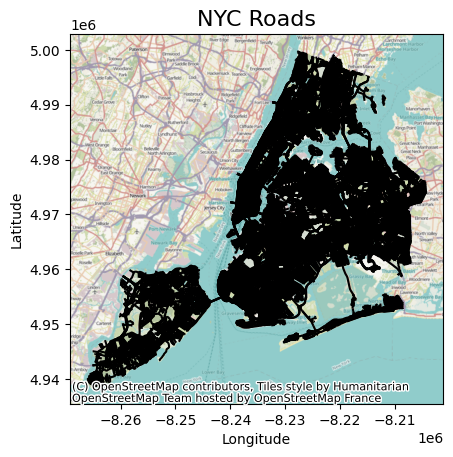

In [8]:
ny_roads_final = ny_roads_final.to_crs(epsg=3857)

ax = ny_roads_final.plot(edgecolor='black')

ctx.add_basemap(ax)

# Add a title and labels
plt.title("NYC Roads", fontsize=16)
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# min_longitude = -74.03  # Example: New York's longitude
# max_longitude = -73.90
# min_latitude = 40.70    # Example: New York's latitude
# max_latitude = 40.80

# Set the zoom level by adjusting xlim and ylim
# ax.set_xlim(min_longitude, max_longitude)
# ax.set_ylim(min_latitude, max_latitude)

# Show the plot
plt.show()

In [9]:
roads_gdf = ny_roads_final.to_crs("EPSG:2263")  # EPSG:2263 is a state plane CRS in feet
points_gdf = gdf_map.to_crs("EPSG:2263")  # Reproject points as well

# Step 3: Buffer the roads by 20 feet
buffer_radius = 20  # Buffer size in feet
roads_gdf['geometry'] = roads_gdf.buffer(buffer_radius)

joined_gdf = gpd.sjoin(points_gdf, roads_gdf, how='inner', predicate='intersects')

In [10]:
# Group by 'OFNS_DESC' and 'LINEARID', then count occurrences of 'CMPLNT_NUM'
summary_table = joined_gdf.groupby(['LINEARID'])['CMPLNT_NUM'].count().reset_index()

# Optional: Rename the count column for clarity
summary_table = summary_table.rename(columns={'CMPLNT_NUM': 'CMPLNT_COUNT'})

In [11]:
# join summary table with the original data
summary_table_new = summary_table.merge(ny_roads_final[['LINEARID', 'geometry']], on='LINEARID', how='inner')
len(summary_table)

11992

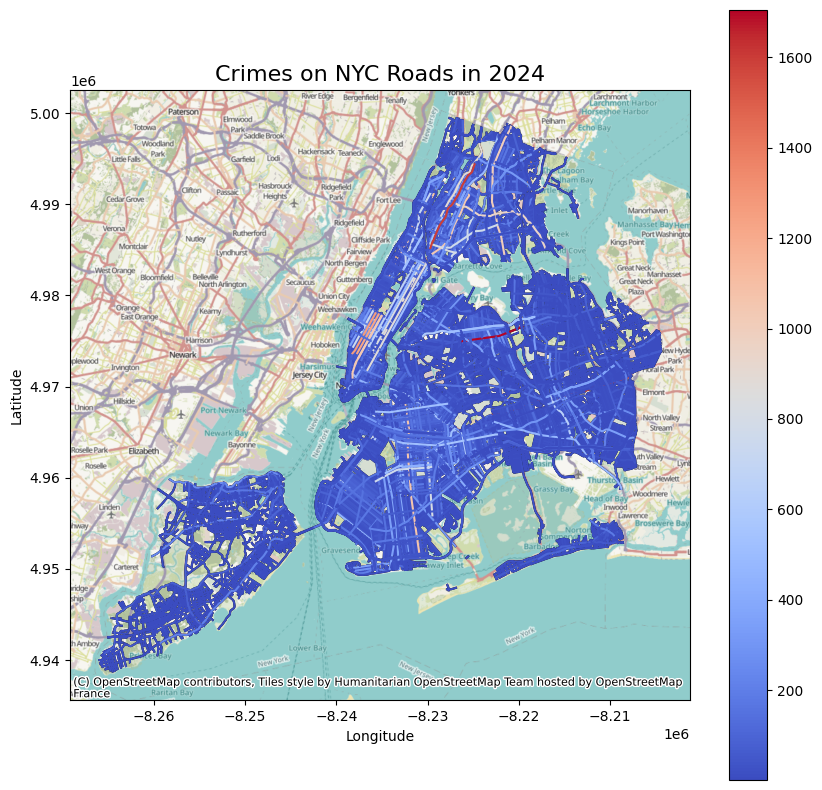

In [12]:
# Map the summary table

summary_table_new = gpd.GeoDataFrame(summary_table_new, geometry='geometry')
crime_counts_per_road = joined_gdf.groupby('LINEARID')['CMPLNT_NUM'].count().reset_index()
summary_table_new = summary_table_new.to_crs(epsg=3857)

# Plot the geometries (points) on the map
ax = summary_table_new.plot(edgecolor='black', figsize=(10, 10))   

summary_table_new.plot(column='CMPLNT_COUNT', ax=ax, legend=True, cmap='coolwarm', markersize=10)
ctx.add_basemap(ax)
plt.title("Crimes on NYC Roads in 2024", fontsize=16)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

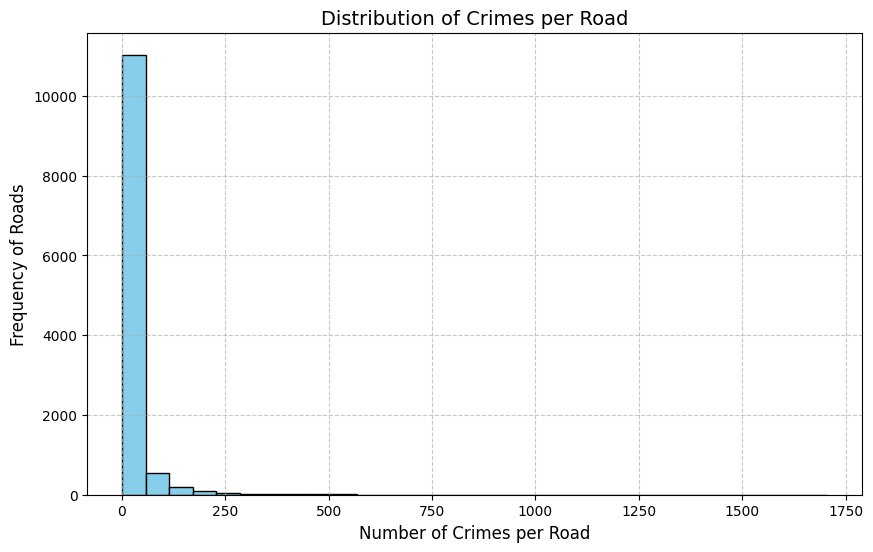

In [13]:
# Step 1: Group by 'LINEARID' and count crimes (CMPLNT_NUM)
crime_counts_per_road = joined_gdf.groupby('LINEARID')['CMPLNT_NUM'].count().reset_index()

# Step 2: Create a histogram to visualize the distribution
plt.figure(figsize=(10, 6))
plt.hist(crime_counts_per_road['CMPLNT_NUM'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Crimes per Road', fontsize=14)
plt.xlabel('Number of Crimes per Road', fontsize=12)
plt.ylabel('Frequency of Roads', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


# Block Level Analysis

Blocks generated in generate_blocks.py

In [14]:
nyc_blocks = gpd.read_file('/Users/naliniramanathan/projects/se_1/team2-wed-spring25/output_data/nyc_blocks.shp')
# Add a road segment identifier 

nyc_blocks['road_seg_id'] = ['ID_{:03d}'.format(i) for i in range(1, len(nyc_blocks) + 1)]

roads_gdf = nyc_blocks.set_crs("3857").to_crs("EPSG:2263")  # EPSG:2263 is a state plane CRS in feet
points_gdf = gdf.to_crs("EPSG:2263")  # Reproject points as well

# Step 3: Buffer the roads by 20 feet
buffer_radius = 20  # Buffer size in feet
roads_gdf['road_geometry'] = roads_gdf['geometry']
roads_gdf['geometry'] = roads_gdf.buffer(buffer_radius)

joined_gdf = gpd.sjoin(points_gdf, roads_gdf, how='inner', predicate='intersects')

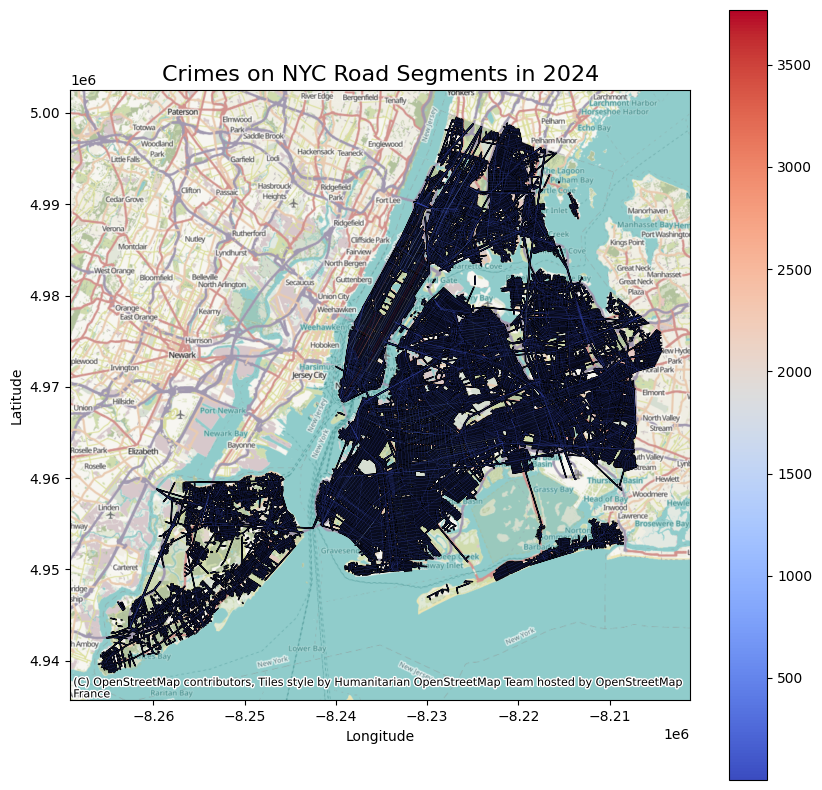

In [15]:
# Map the summary table
summary_table = joined_gdf.groupby(['road_seg_id'])['CMPLNT_NUM'].count().reset_index()

# Optional: Rename the count column for clarity
summary_table = summary_table.rename(columns={'CMPLNT_NUM': 'CMPLNT_COUNT'})

summary_table_new = summary_table.merge(roads_gdf[['road_seg_id', 'geometry']], on='road_seg_id', how='inner')

summary_table_new = gpd.GeoDataFrame(summary_table_new, geometry='geometry')
summary_table_new = summary_table_new.to_crs(epsg=3857)

# Plot the geometries (points) on the map
ax = summary_table_new.plot(edgecolor='black', figsize=(10, 10))   

summary_table_new.plot(column='CMPLNT_COUNT', ax=ax, legend=True, cmap='coolwarm', markersize=10)
ctx.add_basemap(ax)
plt.title("Crimes on NYC Road Segments in 2024", fontsize=16)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

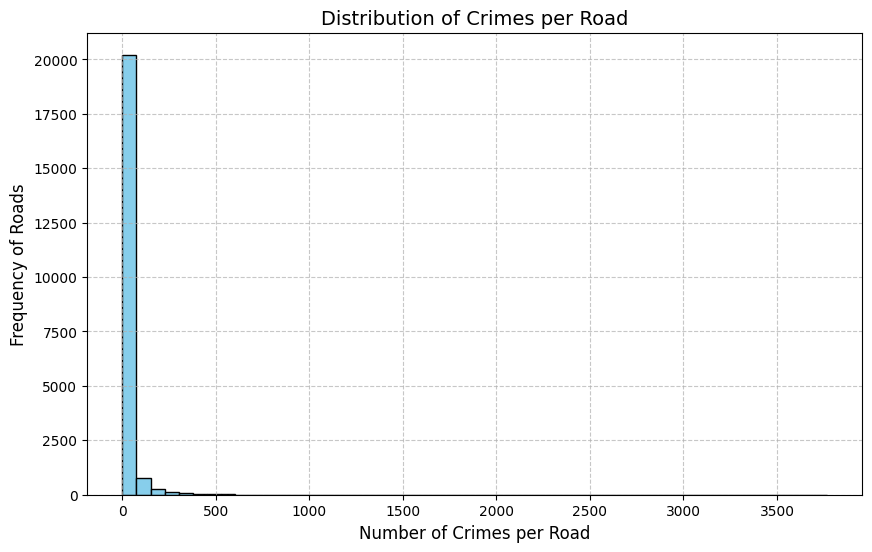

In [16]:
# Step 1: Group by 'LINEARID' and count crimes (CMPLNT_NUM)
crime_counts_per_road = joined_gdf.groupby('road_seg_id')['CMPLNT_NUM'].count().reset_index()

# Step 2: Create a histogram to visualize the distiibution
plt.figure(figsize=(10, 6))
plt.hist(crime_counts_per_road['CMPLNT_NUM'], bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Crimes per Road', fontsize=14)
plt.xlabel('Number of Crimes per Road', fontsize=12)
plt.ylabel('Frequency of Roads', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


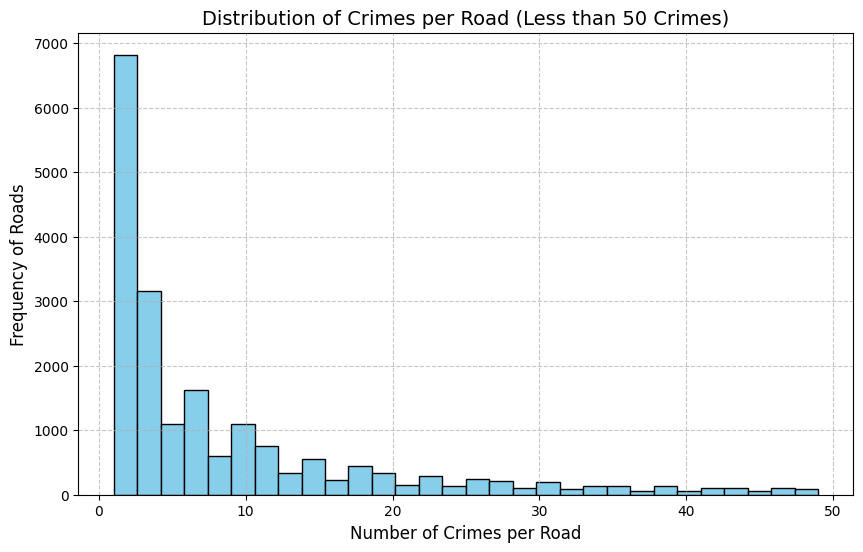

In [17]:
# Now let's look at a narrower bucket
# Step 2: Filter for roads with less than 500 crimes
crime_lim = 50
filtered_crime_counts = crime_counts_per_road[crime_counts_per_road['CMPLNT_NUM'] < crime_lim]

# Step 3: Create a histogram for the filtered data
plt.figure(figsize=(10, 6))

# Use a higher number of bins for finer distribution
plt.hist(filtered_crime_counts['CMPLNT_NUM'], bins=30, color='skyblue', edgecolor='black')

# Title and labels
plt.title(f'Distribution of Crimes per Road (Less than {crime_lim} Crimes)', fontsize=14)
plt.xlabel('Number of Crimes per Road', fontsize=12)
plt.ylabel('Frequency of Roads', fontsize=12)

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Display the histogram


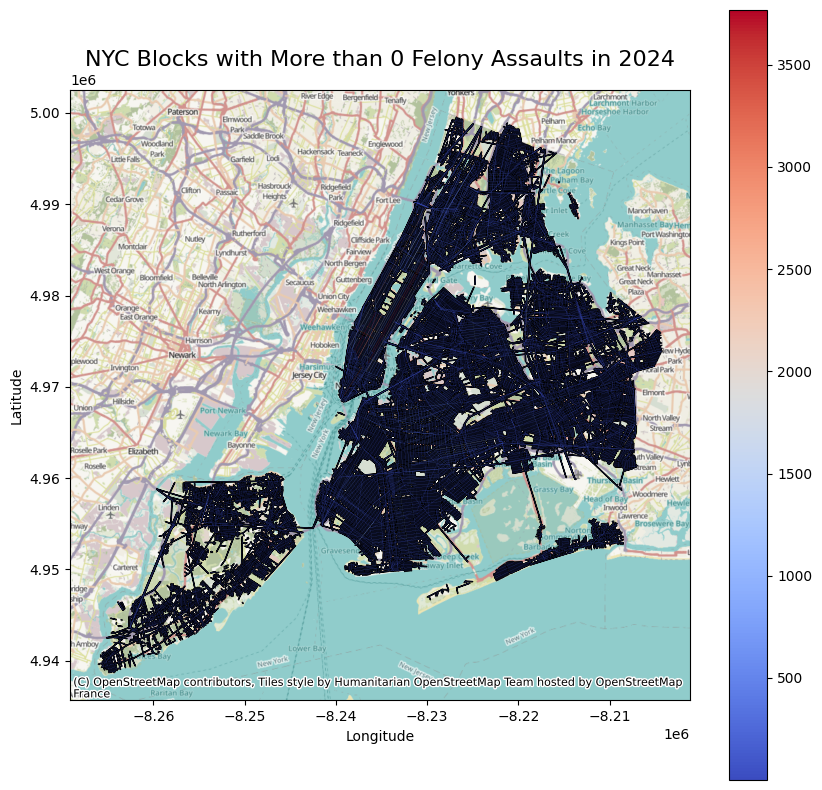

In [18]:
# Map the summary table
crime_lim_2 = 0
summary_table = joined_gdf.groupby(['road_seg_id'])['CMPLNT_NUM'].count().reset_index()

# Optional: Rename the count column for clarity
summary_table = summary_table.rename(columns={'CMPLNT_NUM': 'CMPLNT_COUNT'})

summary_table_new = summary_table.merge(roads_gdf[['road_seg_id', 'geometry']], on='road_seg_id', how='inner')

summary_table_new = gpd.GeoDataFrame(summary_table_new, geometry='geometry')
summary_table_new = summary_table_new.to_crs(epsg=3857)
summary_table_new = summary_table_new[summary_table_new['CMPLNT_COUNT']>crime_lim_2]

# Plot the geometries (points) on the map
ax = summary_table_new.plot(edgecolor='black', figsize=(10, 10))   

summary_table_new.plot(column='CMPLNT_COUNT', ax=ax, legend=True, cmap='coolwarm', markersize=10)
ctx.add_basemap(ax)
plt.title(f"NYC Blocks with More than {crime_lim_2} Felony Assaults in 2024", fontsize=16)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

# Generating the Population-Level CBs

In [19]:
# Load the shapefile into a GeoPandas dataframe
blocks_gdf = gpd.read_file('/Users/naliniramanathan/projects/se_1/team2-wed-spring25/input_data/tl_2024_36_tabblock20.shp')
blocks_gdf.head()

STATEFP20 COUNTYFP20 TRACTCE20 BLOCKCE20          GEOID20  \
0        36        121    971100      1023  361219711001023   
1        36        121    971000      2006  361219710002006   
2        36        003    950300      3013  360039503003013   
3        36        003    951202      1040  360039512021040   
4        36        003    950800      3030  360039508003030   

                  GEOIDFQ20     NAME20 MTFCC20 UR20 UACE20 FUNCSTAT20  \
0  1000000US361219711001023  Block1023   G5040    R   None          S   
1  1000000US361219710002006  Block2006   G5040    R   None          S   
2  1000000US360039503003013  Block3013   G5040    R   None          S   
3  1000000US360039512021040  Block1040   G5040    R   None          S   
4  1000000US360039508003030  Block3030   G5040    R   None          S   

   ALAND20  AWATER20   INTPTLAT20    INTPTLON20  HOUSING20  POP20  \
0   844806     27408  +42.5752568  -078.0778736          2      6   
1   943980     21822  +42.5665020  -078.3912098          9     30   
2  2847621     10520  +42.4282985  -078.1726457        114    407   
3   544101     17953  +42.0698069  -078.2932867          3      8   
4  1799132     42765  +42.2409037  -077.8295608         10      4   

                                            geometry  
0  POLYGON ((-78.08259 42.56623, -78.08231 42.566...  
1  POLYGON ((-78.39606 42.57156, -78.39603 42.571...  
2  POLYGON ((-78.19143 42.43592, -78.1727 42.4357...  
3  POLYGON ((-78.30184 42.06941, -78.30149 42.069...  
4  POLYGON ((-77.83902 42.24468, -77.83752 42.244...

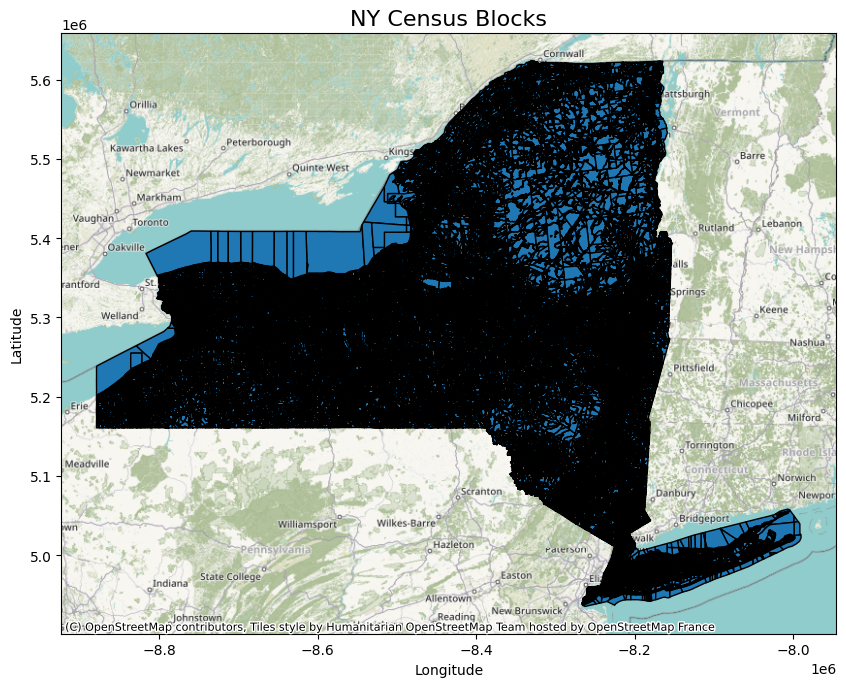

In [20]:
# Ensure the geometry column is in the correct CRS (WGS84)
blocks_gdf = blocks_gdf.to_crs(epsg=3857)

# Plot the geometries (blocks) on the map
ax = blocks_gdf.plot(edgecolor='black', figsize=(10, 10))

# Add a basemap for context
ctx.add_basemap(ax)

# Add a title and labels
plt.title("NY Census Blocks", fontsize=16)
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Show the plot
plt.show()

In [21]:
joined_gdf = joined_gdf.to_crs(epsg=3857)
joined_gdf.drop('index_right', axis=1, inplace=True)


In [22]:
blocks_gdf['blocks_geom'] = blocks_gdf['geometry']

joined_gdf_blocks = gpd.sjoin(joined_gdf, blocks_gdf, how='inner', predicate='intersects')

# Rename 'index_right' to 'block_id' and assign the necessary columns
joined_gdf_blocks = joined_gdf_blocks.rename(columns={'index_right': 'block_id'})
joined_gdf_blocks['intersection_geometry'] = joined_gdf_blocks['geometry'].intersection(joined_gdf_blocks['blocks_geom'])
# Calculate the intersection area
joined_gdf_blocks['intersection_area'] = joined_gdf_blocks['intersection_geometry'].area

In [23]:
# If population data is in summary_table_new, sum the population per block
# Assuming 'population' is the column in summary_table_new and 'block_id' is the identifier for blocks
joined_gdf_blocks['total_population'] = joined_gdf_blocks.groupby('GEOIDFQ20')['POP20'].transform('max')

# Sort by block_id, then by maximum intersection_area, and if there's a tie, prioritize maximum population
# First, sort by intersection_area and then by population (in descending order)
joined_gdf_blocks_sorted = joined_gdf_blocks.sort_values(by=['road_seg_id', 'intersection_area', 'total_population'], ascending=[True, False, False])

# Drop duplicates and keep only the first occurrence for each block_id (which will be the max overlap or max population in case of tie)
result = joined_gdf_blocks_sorted.drop_duplicates(subset=['road_seg_id', 'CMPLNT_NUM'], keep='first')

# Now `result` contains the block with the highest overlap, and in case of ties, the highest population

In [24]:
date_filter = '2024-01-01'
crime_filter = 'FELONY ASSAULT'

filtered_data = result[result['CMPLNT_FR_DT'] >= date_filter]
filtered_data = filtered_data[filtered_data['OFNS_DESC'] == crime_filter]

filtered_grouped_data = filtered_data.groupby(['road_seg_id', 'road_geometry', 'total_population'])['CMPLNT_NUM'].count().reset_index()

# Join with the population-level data


Text(0.5, 0, 'Total Population per Block')

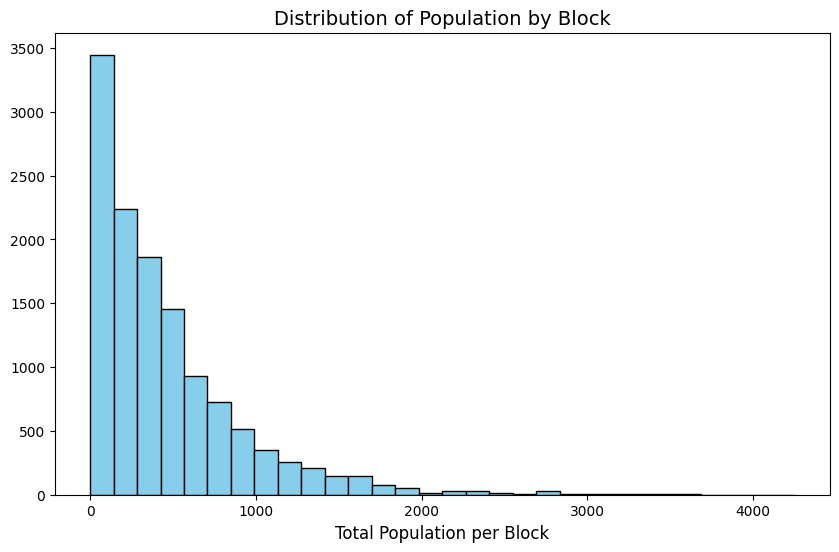

In [25]:
# Distribution of population per block
filtered_grouped_data = filtered_grouped_data.sort_values(by='total_population', ascending=False)
# filtered_grouped_data = filtered_grouped_data[filtered_grouped_data['ratio'] < 0.3]
plt.figure(figsize=(10, 6))
plt.hist(filtered_grouped_data['total_population'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Population by Block', fontsize=14)
plt.xlabel('Total Population per Block', fontsize=12)

Text(0.5, 0, 'Crime to Population Ratio')

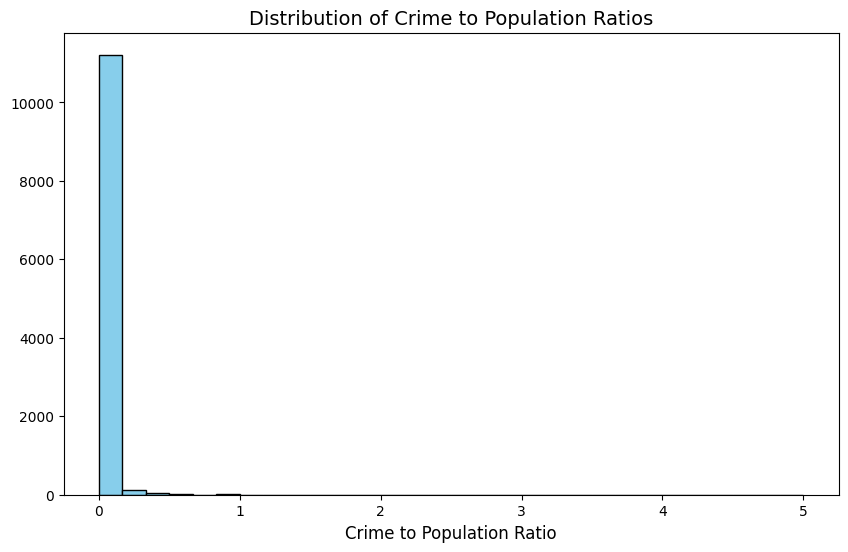

In [26]:
# Create histogram of ratios
filtered_grouped_data = filtered_grouped_data[filtered_grouped_data['total_population'] > 0]
filtered_grouped_data['ratio'] = filtered_grouped_data['CMPLNT_NUM'] / filtered_grouped_data['total_population']
filtered_grouped_data = filtered_grouped_data.sort_values(by='ratio', ascending=False)
# filtered_grouped_data = filtered_grouped_data[filtered_grouped_data['ratio'] < 0.3]
plt.figure(figsize=(10, 6))
plt.hist(filtered_grouped_data['ratio'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Crime to Population Ratios', fontsize=14)
plt.xlabel('Crime to Population Ratio', fontsize=12)

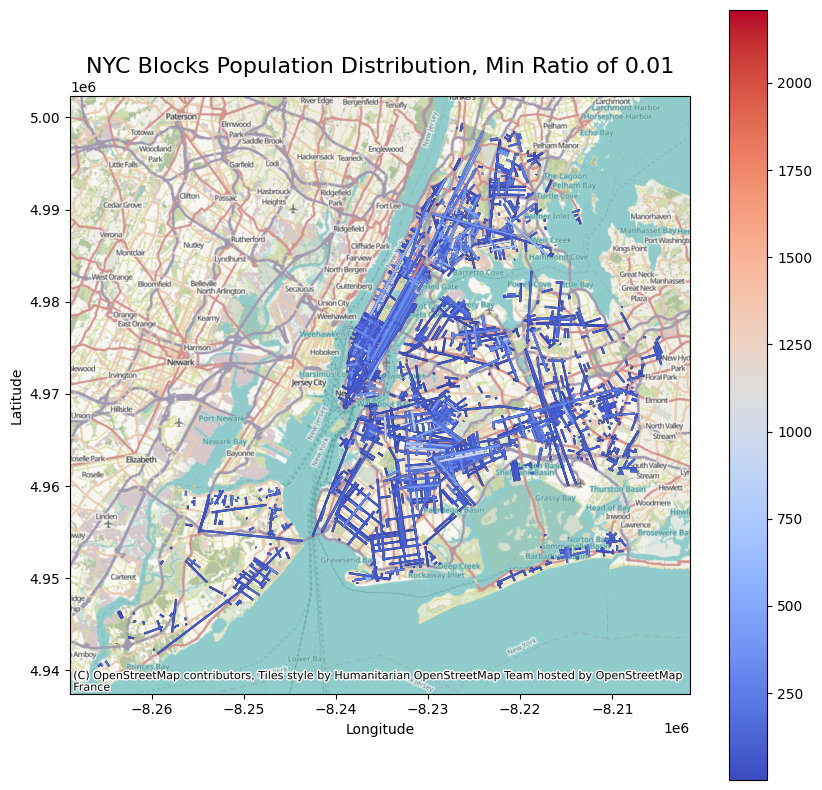

In [27]:
# Map the summary table
min_ratio = 0.01

filtered_grouped_data = gpd.GeoDataFrame(filtered_grouped_data, geometry='road_geometry')
filtered_grouped_data = filtered_grouped_data.to_crs(epsg=3857)

filtered_grouped_data_for_map = filtered_grouped_data[filtered_grouped_data['ratio']>min_ratio]
# Plot the geometries (points) on the map
ax = filtered_grouped_data_for_map.plot(edgecolor='black', figsize=(10, 10))   

filtered_grouped_data_for_map.plot(column='total_population', ax=ax, legend=True, cmap='coolwarm', markersize=10)
ctx.add_basemap(ax)
plt.title(f"NYC Blocks Population Distribution, Min Ratio of {min_ratio}", fontsize=16)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

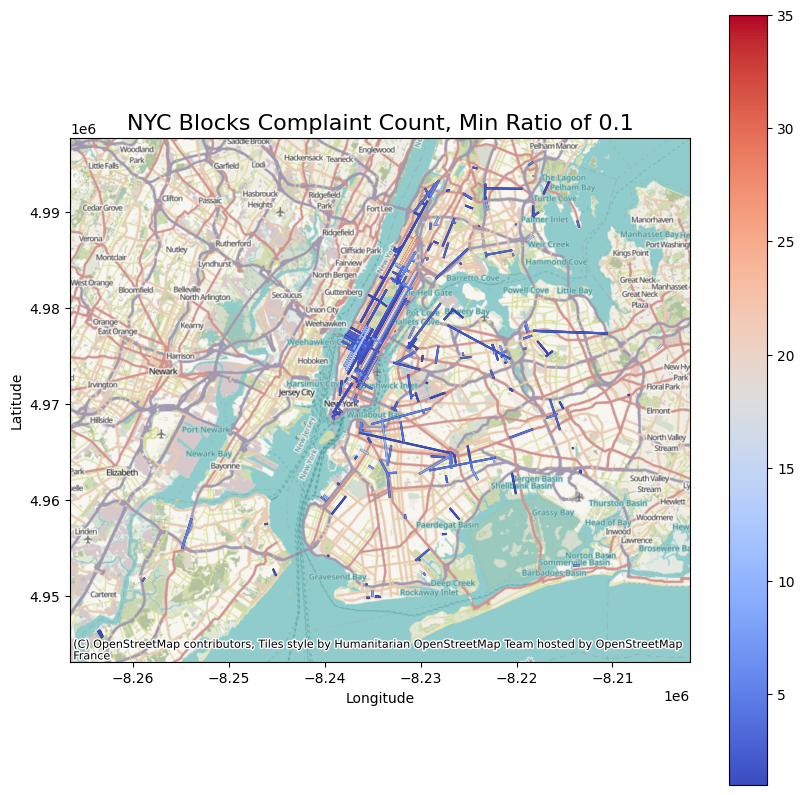

In [28]:
# Map the summary table
min_ratio = 0.1

filtered_grouped_data = gpd.GeoDataFrame(filtered_grouped_data, geometry='road_geometry')
filtered_grouped_data = filtered_grouped_data.to_crs(epsg=3857)

filtered_grouped_data_for_map = filtered_grouped_data[filtered_grouped_data['ratio']>min_ratio]
# Plot the geometries (points) on the map
ax = filtered_grouped_data_for_map.plot(edgecolor='black', figsize=(10, 10))   

filtered_grouped_data_for_map.plot(column='CMPLNT_NUM', ax=ax, legend=True, cmap='coolwarm', markersize=10)
ctx.add_basemap(ax)
plt.title(f"NYC Blocks Complaint Count, Min Ratio of {min_ratio}", fontsize=16)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [29]:
columns_of_interest = ['road_seg_id', 'road_geometry', 'total_population', 'CMPLNT_NUM', 'Lat_Lon', 'CMPLNT_FR_DT', 'CMPLNT_FR_TM', 'OFNS_DESC']
result_final = result[columns_of_interest]

In [30]:
result_final.to_file('output_data/complaint_level_data_with_road_geoms.shp')
filtered_grouped_data.to_file('output_data/filtered_grouped_data.shp')

/var/folders/7b/0zqwym191dq_5jvhhbf5lfgr0000gn/T/ipykernel_38641/3122640160.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  result_final.to_file('output_data/complaint_level_data_with_road_geoms.shp')
/opt/anaconda3/envs/se_1/lib/python3.13/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'road_seg_id' to 'road_seg_i'
  ogr_write(
/opt/anaconda3/envs/se_1/lib/python3.13/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'total_population' to 'total_popu'
  ogr_write(
/opt/anaconda3/envs/se_1/lib/python3.13/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'CMPLNT_FR_DT' to 'CMPLNT_FR_'
  ogr_write(
/opt/anaconda3/envs/se_1/lib/python3.13/site-packages/pyogrio/raw.py:723: RuntimeWarning: Field CMPLNT_FR_ create as date field, though DateTime requested.
  ogr_write(
/opt/anaconda3/envs/se_1/lib/python3.13/site-packages/pyogrio/raw.

In [31]:
# Save centroids and reupload with those instead
filtered_grouped_data['centroid'] = filtered_grouped_data['road_geometry'].centroid

In [32]:
filtered_grouped_data.columns

Index(['road_seg_id', 'road_geometry', 'total_population', 'CMPLNT_NUM',
       'ratio', 'centroid'],
      dtype='object')

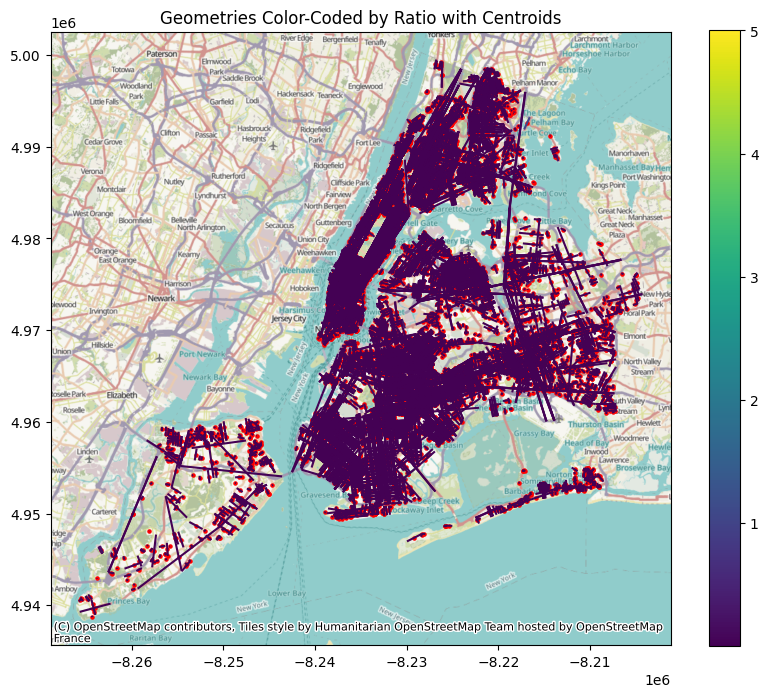

In [33]:
# Map the centroids as a final check


# Assuming 'gdf' is your GeoDataFrame and 'value_column' is the variable you want to color by
ax = filtered_grouped_data.plot(column='ratio', cmap='viridis', legend=True, figsize=(10, 8))

# Plot the centroids on top of the geometries
filtered_grouped_data['centroid'].plot(ax=ax, color='red', marker='o', markersize=5)
ctx.add_basemap(ax)
# Optional: Add title or customize
plt.title("Geometries Color-Coded by Ratio with Centroids")
plt.show()

In [34]:
## Save the road-level and complaint-level data
filtered_grouped_data.columns
columns_of_interest = ['road_seg_id', 'total_population', 'CMPLNT_NUM', 'ratio', 'centroid']
filtered_grouped_data_centroid = filtered_grouped_data[columns_of_interest]
filtered_grouped_data_centroid.to_file('output_data/filtered_grouped_data_centroid.shp')

/var/folders/7b/0zqwym191dq_5jvhhbf5lfgr0000gn/T/ipykernel_38641/1182546251.py:5: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  filtered_grouped_data_centroid.to_file('output_data/filtered_grouped_data_centroid.shp')
/opt/anaconda3/envs/se_1/lib/python3.13/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'road_seg_id' to 'road_seg_i'
  ogr_write(
/opt/anaconda3/envs/se_1/lib/python3.13/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'total_population' to 'total_popu'
  ogr_write(


In [35]:
# Open each and check
result_final = gpd.read_file('output_data/complaint_level_data_with_road_geoms.shp')
filtered_grouped_data = gpd.read_file('output_data/filtered_grouped_data_centroid.shp')
result_final.head()
filtered_grouped_data.head()

road_seg_i  total_popu  CMPLNT_NUM     ratio  \
0   ID_17679           1           5  5.000000   
1   ID_10279           1           3  3.000000   
2   ID_14291           6          16  2.666667   
3   ID_14265           5          10  2.000000   
4   ID_12852           1           2  2.000000   

                           geometry  
0  POINT (-8233178.407 4984120.014)  
1  POINT (-8229825.909 4954275.281)  
2  POINT (-8236057.908 4976350.101)  
3  POINT (-8232192.506 4982540.966)  
4  POINT (-8236097.037 4967788.146)

In [36]:
# Define the output GeoJSON file path
geojson_file_path = 'output_data/filtered_grouped_data_centroid.geojson'

# Write the GeoDataFrame to a GeoJSON file
filtered_grouped_data.to_file(geojson_file_path, driver='GeoJSON')

# Print a success message
print(f"GeoJSON file saved to: {geojson_file_path}")

GeoJSON file saved to: output_data/filtered_grouped_data_centroid.geojson
